# House Prices: Advanced Regression Techniques

Kaggle competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1039]:
#imports

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn import metrics
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import os
from scipy.stats import skew

In [1040]:
#show current working directory

os.getcwd()

'/Users/sglembocki/Machine-Learning/HousePrices'

In [1041]:
#load in csv files

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Exploration

In [1042]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1043]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [1044]:
#delete features that contain mostly NaN values

train_clean = train

del train_clean['Alley']
del train_clean['FireplaceQu']
del train_clean['PoolQC']
del train_clean['Fence']
del train_clean['MiscFeature']

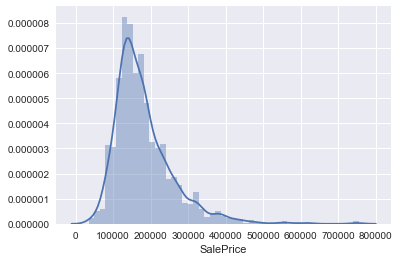

In [1045]:
#sales price distribution

sns.distplot(train_clean['SalePrice'])

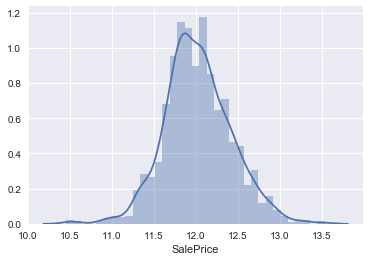

In [1046]:
#normalize sales price

train_clean['SalePrice'] = np.log(train_clean['SalePrice'])
sns.distplot(train_clean['SalePrice'])

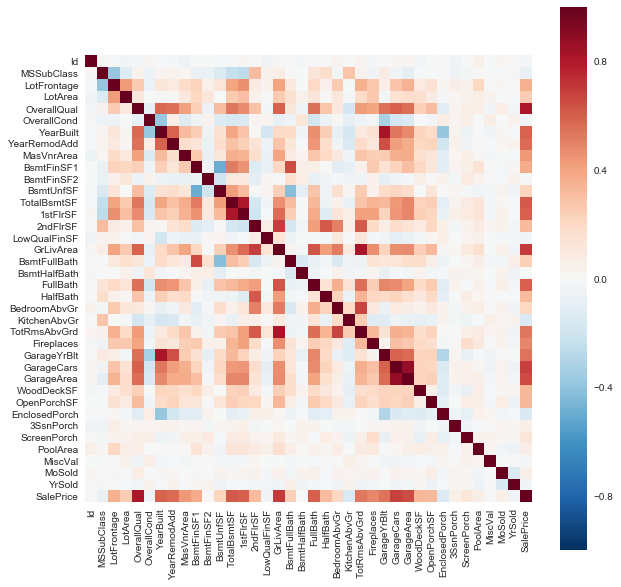

In [1047]:
#correlation for all numeric features

corr = train_clean.select_dtypes(include = ['float64', 'int64']).corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr, square = True)

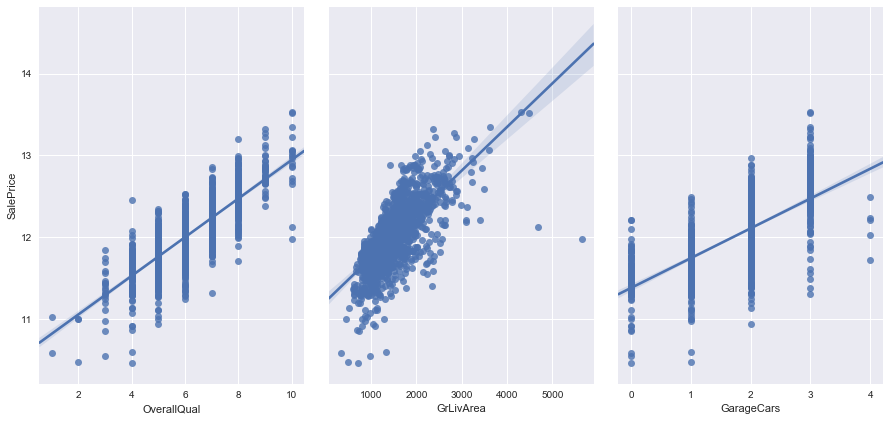

In [1048]:
#plot features w/ strongest correlation to response

sns.pairplot(train_clean, x_vars = ['OverallQual', 'GrLivArea', 'GarageCars'], y_vars = 'SalePrice', size = 6, aspect = 0.7, kind = 'reg')

## Feature Engineering

In [1049]:
#train['TotalSquareFeet'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF'] #total square feet
#train['TotalSquareFeet'].head()

In [1050]:
#sns.pairplot(train_clean, x_vars = 'TotalSquareFeet', y_vars = 'SalePrice', size = 6, aspect = 0.7, kind = 'reg')

## Feature Selection

In [1051]:
corr = train_clean.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.817184
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489449
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355878
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209044
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057329
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

In [1052]:
df = train_clean[[
    'OverallQual',
    'GrLivArea',
    'GarageCars',
    'GarageArea',
    'SalePrice',
    'TotalBsmtSF'
    #'TotalSquareFeet'
]]
X, y = df.drop('SalePrice', axis = 1), df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

## Linear Regression

In [1053]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
predictions = linreg.predict(X_test)
print np.sqrt(metrics.mean_squared_error(y_test, predictions))

0.170657909863


In [1054]:
df2 = train_clean[[
    'OverallQual',
    'GrLivArea',
    'GarageCars',
    'GarageArea',
    'TotalBsmtSF',
    '1stFlrSF',
    'FullBath',
    #'TotalSquareFeet',
    'TotRmsAbvGrd',
    'YearBuilt',
    'YearRemodAdd',
    'SalePrice'
]]
df2.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice
0,7,1710,2,548,856,856,2,8,2003,2003,12.247694
1,6,1262,2,460,1262,1262,2,6,1976,1976,12.109011
2,7,1786,2,608,920,920,2,6,2001,2002,12.317167
3,7,1717,3,642,756,961,1,7,1915,1970,11.849398
4,8,2198,3,836,1145,1145,2,9,2000,2000,12.429216


In [1055]:
X_new, y_new = df2.drop('SalePrice', axis = 1), df2['SalePrice']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, random_state = 1)

In [1056]:
linreg.fit(X_train_new, y_train_new)
predictions_new = linreg.predict(X_test_new)
print np.sqrt(metrics.mean_squared_error(y_test_new, predictions_new))

0.157845148169


In [1057]:
df3 = train_clean.select_dtypes(include = ['float64', 'int64'])
df3['LotFrontage'] = df3['LotFrontage'].fillna(test['LotFrontage'].median())
df3['MasVnrArea'] = df3['MasVnrArea'].fillna(test['MasVnrArea'].median())
df3['GarageYrBlt'] = df3['GarageYrBlt'].fillna(test['GarageYrBlt'].median())
del df3['Id']
df3.info()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
MSSubClass       1460 non-null int64
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1460 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
Fireplaces       1460 non-null int64
G

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1058]:
X_all, y_all = df3.drop('SalePrice', axis = 1), df3['SalePrice']
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, random_state = 1)

In [1059]:
linreg.fit(X_train_all, y_train_all)
predictions_all = linreg.predict(X_test_all)
print np.sqrt(metrics.mean_squared_error(y_test_all, predictions_all))

0.14309914485


In [1060]:
#skewness of numerical features

skewness = train_clean.select_dtypes(include = ['float64', 'int64']).apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewness

MSSubClass        1.406210
LotArea          12.195142
OverallCond       0.692355
YearBuilt        -0.612831
YearRemodAdd     -0.503044
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
HalfBath          0.675203
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
dtype: float64

In [1061]:
#scale train data

scaled_data = preprocessing.scale(X_train_all)
X_train_scaled = pd.DataFrame(
    scaled_data,
    index = X_train_all.index,
    columns = X_train_all.columns
)
X_train_scaled.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
6,-0.873173,0.239442,-0.050850,1.360274,-0.540582,1.071350,0.947089,0.491840,1.972617,-0.275830,...,0.761337,1.287723,0.150059,-0.364415,-0.117811,-0.283044,-0.066847,-0.090611,0.634747,-0.621957
807,0.314707,3.271805,1.060991,-0.828022,0.345552,-1.599797,0.898560,-0.585939,1.843438,-0.275830,...,0.249369,-0.777481,3.923155,-0.364415,-0.117811,-0.283044,-0.066847,-0.090611,-0.481497,0.891472
955,0.789859,0.547073,-0.340912,-0.098590,0.345552,-0.841323,-1.722000,1.865140,0.067238,-0.275830,...,0.078713,-0.777481,-0.693339,-0.364415,-0.117811,-0.283044,-0.066847,-0.090611,0.634747,-0.621957
1040,-0.873173,0.810757,0.248363,-0.828022,-1.426716,-0.478575,0.704445,-0.197707,-0.613101,3.929625,...,0.040789,-0.777481,-0.693339,-0.364415,-0.117811,-0.283044,-0.066847,-0.090611,-1.969822,-1.378671
701,-0.873173,0.459179,-0.098472,0.630842,-0.540582,-0.082849,-0.799951,0.387539,-0.974800,-0.275830,...,0.249369,-0.777481,-0.693339,-0.364415,-0.117811,-0.283044,-0.066847,-0.090611,0.262666,-1.378671


In [1062]:
#scale test data

scaled_data_test = preprocessing.scale(X_test_all)
X_test_scaled = pd.DataFrame(
    scaled_data_test,
    index = X_test_all.index,
    columns = X_test_all.columns
)
X_test_scaled.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
258,0.062324,0.537033,0.230984,0.714400,-0.446285,1.022940,0.872268,0.309954,-0.129039,-0.328323,...,0.443222,-0.682022,0.805365,-0.34542,11.490925,-0.228601,-0.074005,-0.173926,-0.511856,0.150656
267,0.412294,-0.474407,-0.198501,-0.702752,2.394891,-1.058817,0.678313,-0.537744,-0.089334,-0.328323,...,-1.018162,1.326160,-0.355888,-0.34542,-0.117611,-0.228601,-0.074005,-0.173926,0.216516,0.150656
288,-0.870932,-0.120403,-0.047463,-0.702752,-0.446285,-0.118668,-0.776353,-0.384961,0.078827,-0.328323,...,-0.837745,-0.682022,-0.742972,-0.34542,-0.117611,-0.228601,-0.074005,-0.173926,-1.604413,1.636853
649,2.862089,-2.446714,-0.886529,-1.411329,0.500774,-0.017938,-0.630886,-0.537744,-0.666220,2.822150,...,-2.100670,-0.682022,-0.742972,-0.34542,-0.117611,-0.228601,-0.074005,-0.173926,2.037445,-0.592443
1233,-0.870932,-0.120403,0.201713,-0.702752,-0.446285,-0.387282,-1.164264,0.349382,1.363390,-0.328323,...,0.294378,-0.682022,-0.742972,-0.34542,-0.117611,-0.228601,-0.074005,-0.173926,-0.511856,1.636853


In [1063]:
linreg.fit(X_train_all, y_train_all)
predictions_new = linreg.predict(X_test_all)
print np.sqrt(metrics.mean_squared_error(y_test_all, predictions_all))

0.14309914485


## Linear Regression with Ridge Regularization

In [1064]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_scaled, y_train_new)
alpha = ridge.alpha_
print("Best alpha :", alpha)
predictions_ridge = ridge.predict(X_test_scaled)
print np.sqrt(metrics.mean_squared_error(y_test_new, predictions_ridge))

('Best alpha :', 60.0)
0.144402351684


In [1065]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [1068]:
Id = test['Id']
test_clean = test.select_dtypes(include = ['float64', 'int64'])
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 37 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
MasVnrArea       1444 non-null float64
BsmtFinSF1       1458 non-null float64
BsmtFinSF2       1458 non-null float64
BsmtUnfSF        1458 non-null float64
TotalBsmtSF      1458 non-null float64
1stFlrSF         1459 non-null int64
2ndFlrSF         1459 non-null int64
LowQualFinSF     1459 non-null int64
GrLivArea        1459 non-null int64
BsmtFullBath     1457 non-null float64
BsmtHalfBath     1457 non-null float64
FullBath         1459 non-null int64
HalfBath         1459 non-null int64
BedroomAbvGr     1459 non-null int64
KitchenAbvGr     1459 non-null int64
TotRmsAbvGrd     1459 non-

In [1069]:
del test_clean['Id']
test_clean['LotFrontage'] = test_clean['LotFrontage'].fillna(test_clean['LotFrontage'].median())
test_clean['MasVnrArea'] = test_clean['MasVnrArea'].fillna(test_clean['MasVnrArea'].median())
test_clean['BsmtFinSF1'] = test_clean['BsmtFinSF1'].fillna(test_clean['BsmtFinSF1'].median())
test_clean['BsmtFinSF2'] = test_clean['BsmtFinSF2'].fillna(test_clean['BsmtFinSF2'].median())
test_clean['BsmtUnfSF'] = test_clean['BsmtUnfSF'].fillna(test_clean['BsmtUnfSF'].median())
test_clean['TotalBsmtSF'] = test_clean['TotalBsmtSF'].fillna(test_clean['TotalBsmtSF'].median())
test_clean['BsmtFullBath'] = test_clean['BsmtFullBath'].fillna(test_clean['BsmtFullBath'].median())
test_clean['BsmtHalfBath'] = test_clean['BsmtHalfBath'].fillna(test_clean['BsmtHalfBath'].median())
test_clean['GarageYrBlt'] = test_clean['GarageYrBlt'].fillna(test_clean['GarageYrBlt'].median())
test_clean['GarageCars'] = test_clean['GarageCars'].fillna(test_clean['GarageCars'].median())
test_clean['GarageArea'] = test_clean['GarageArea'].fillna(test_clean['GarageArea'].median())

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [1070]:
pd.DataFrame(Id).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 1 columns):
Id    1459 non-null int64
dtypes: int64(1)
memory usage: 11.5 KB


In [1071]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 36 columns):
MSSubClass       1459 non-null int64
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
MasVnrArea       1459 non-null float64
BsmtFinSF1       1459 non-null float64
BsmtFinSF2       1459 non-null float64
BsmtUnfSF        1459 non-null float64
TotalBsmtSF      1459 non-null float64
1stFlrSF         1459 non-null int64
2ndFlrSF         1459 non-null int64
LowQualFinSF     1459 non-null int64
GrLivArea        1459 non-null int64
BsmtFullBath     1459 non-null float64
BsmtHalfBath     1459 non-null float64
FullBath         1459 non-null int64
HalfBath         1459 non-null int64
BedroomAbvGr     1459 non-null int64
KitchenAbvGr     1459 non-null int64
TotRmsAbvGrd     1459 non-null int64
Fireplaces       1459 non-

In [1072]:
result = linreg.predict(test_clean)
result = pd.DataFrame(abs(result), columns = ['SalePrice'])
result = pd.concat([Id, pd.DataFrame(result)], axis = 1, join_axes = [Id.index])
result['SalePrice'] = np.exp(result['SalePrice'])
result.head()

,Id,SalePrice
0,1461,117640.500485
1,1462,142834.934482
2,1463,165176.114949
3,1464,195080.108520
4,1465,182592.600491


In [1073]:
#save predictions to csv file for submissions

result.to_csv('submission.csv', sep = ',', index = False)